In [108]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [109]:
# Import data
ticker = 'NVCR'
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2005-1-1', end = '1-14-2021')['Adj Close']

In [110]:
# Estimate historycal log returns
log_returns = np.log(1+data.pct_change()) 

In [111]:
log_returns.tail()

NVCR
Date                
2021-01-08  0.040668
2021-01-11 -0.001704
2021-01-12  0.033076
2021-01-13  0.006407
2021-01-14  0.011240

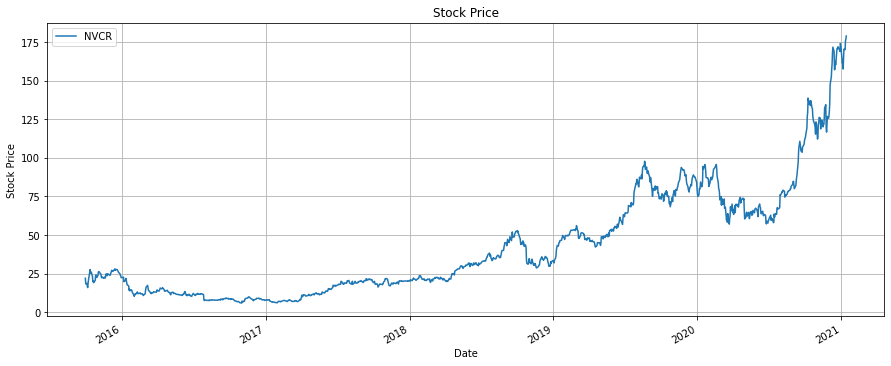

In [112]:
# Plot stock price
data.plot(figsize=(15,6))
plt.ylabel('Stock Price')
plt.xlabel ('Date')
plt.title('Stock Price')
plt.grid(True)

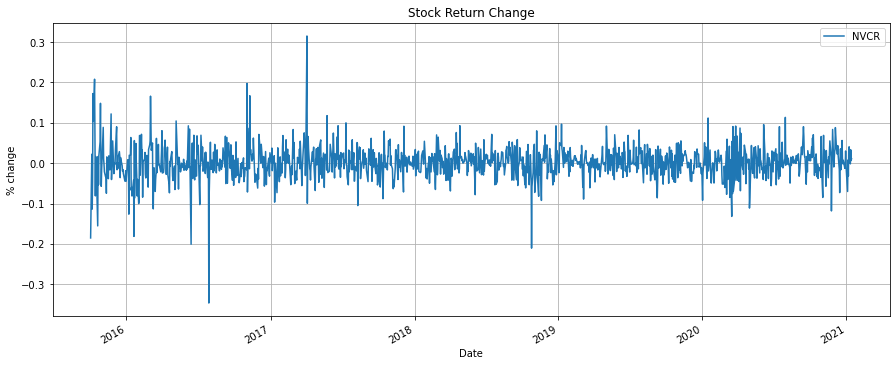

In [113]:
# Plot stock return
log_returns.plot(figsize = (15,6))
plt.ylabel('% change')
plt.xlabel('Date')
plt.title('Stock Return Change')
plt.grid(True)

In [127]:
# Calulate log return mean
u = log_returns.mean()
u

NVCR    0.001575
dtype: float64

In [128]:
# Calculate log return variance
var = log_returns.var()
var

NVCR    0.00168
dtype: float64

$$
drift = u - \frac{1}{2} \cdot var
$$



The best approxiamtion of future rates of return of a stock

In [129]:
# Calculate drift
# Hence we are predicting daily stock price, this number is NOT annualized. 
drift = u - (0.5*var)
drift

NVCR    0.000735
dtype: float64

In [130]:
# Calculate standard deviation 
stdev = log_returns.std()
stdev

NVCR    0.04099
dtype: float64


### Brownian motion###


$$
r = drift + stdev * e^r
$$


In [131]:
type(drift)

pandas.core.series.Series

In [132]:
type(stdev)

pandas.core.series.Series

In [133]:
# Convert values to arrays
np.array(drift) 

array([0.00073468])

In [134]:
np.array(stdev)

array([0.04098991])

In [135]:
# Where 0.95 : an event has 95% chance of occuring
norm.ppf(0.95) 

1.6448536269514722

In [136]:
# The distance between the mean and the event is going to be approximately 1.64 standard deviations

In [137]:
# to randomize and generate a 10,2 dimension array. The array below contains randomly generated probilities
x = np.random.rand(10000,2) 
x

array([[0.319651  , 0.16531775],
       [0.40368963, 0.46923399],
       [0.46900744, 0.94797669],
       ...,
       [0.56206283, 0.67356931],
       [0.63153451, 0.99233179],
       [0.17724177, 0.53899176]])

In [138]:
# Obtain the distance of these probabilites from the mean
# The first number in the first row correspondes the first number of the first row above
norm.ppf(x) 

array([[-0.46867494, -0.97283464],
       [-0.24380835, -0.07719555],
       [-0.07776513,  1.62554432],
       ...,
       [ 0.15620132,  0.44979069],
       [ 0.33592029,  2.42433581],
       [-0.92592774,  0.09789397]])

In [139]:
# Generate a random number 'z' that corresposnds to the distance between the mean and the events, 
# expressed as the number of standard deviation
# The new array uses the probailities generated by the random function and 
# converted them into distances from the mean 0, measured by the number of standard deviations. 
# This expression is the 'z' in our formula. 
z = norm.ppf(np.random.rand(10000,2))
z

array([[ 1.7776254 , -0.16008578],
       [ 0.39933027, -0.48630896],
       [ 1.32314583, -0.76079002],
       ...,
       [ 0.67640575,  0.79398005],
       [-0.62212723, -1.37377637],
       [ 0.46973644,  1.24855081]])

In [140]:
# Calucalte stock prices
t_intervals = 365 # Number of days we are forecasting for 
iterations = 10000 # We want Python to run the loop 10 times 

$$
daily_returns = e^rn
$$

$$
r = drift + stdev*z
$$

In [141]:
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals,iterations)))

In [142]:
daily_returns

array([[0.95750229, 0.94521083, 1.04536519, ..., 1.00998281, 0.99812615,
        1.02775138],
       [0.98059922, 1.0491862 , 0.99554881, ..., 1.07989819, 1.11414425,
        0.98552371],
       [1.02879121, 0.97570241, 0.97396004, ..., 0.93265057, 0.96166726,
        0.97681705],
       ...,
       [1.04296555, 1.015636  , 1.02690636, ..., 1.05247796, 1.04866125,
        0.96569464],
       [1.00104174, 1.0091517 , 0.96967419, ..., 0.96698546, 0.95840489,
        0.99459891],
       [1.00534622, 1.00461013, 0.95529427, ..., 1.04931455, 1.01257847,
        0.98116491]])

#### Create a price list

$$
S_t = S_0 \mathbin{\cdot} daily\_return_t
$$
<br />

$$
S_{t+1} = S_t \mathbin{\cdot} daily\_return_{t+1}
$$

<br /> 
$$...$$
<br />  

$$
S_{t+999} = S_{t+998} \mathbin{\cdot} daily\_return_{t+999}
$$



In [143]:
# Determining the first datapoint in the equation, which is the latest known price return in our dataset
S0 = data.iloc[-1]
S0

NVCR    178.940002
Name: 2021-01-14 00:00:00, dtype: float64

In [144]:
# Creating an array, same size as the daily return filed with 0s
price_list = np.zeros_like(daily_returns)

In [145]:
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
# Replace zeros with the prices by creating a loop
# S0 is the first elemnt on each - here 10 - columns as we will have 10 iterations generated from the same
# starting point
price_list[0]=S0
price_list

array([[178.94000244, 178.94000244, 178.94000244, ..., 178.94000244,
        178.94000244, 178.94000244],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [147]:
# After generating all the elements of the formula, fill it
for t in range (1, t_intervals):
    price_list[t] = price_list[t-1]*daily_returns[t]

In [150]:
price_list

array([[178.94000244, 178.94000244, 178.94000244, ..., 178.94000244,
        178.94000244, 178.94000244],
       [175.46842747, 187.74138159, 178.14350568, ..., 193.23698458,
        199.3649746 , 176.3496156 ],
       [180.52037584, 183.17971769, 173.50465558, ..., 180.22258398,
        191.72276824, 172.2613116 ],
       ...,
       [125.25220479, 115.50164538,  35.17578069, ..., 410.70172247,
        860.79166453, 539.71777442],
       [125.3826856 , 116.55868153,  34.10904656, ..., 397.14259429,
        824.98694433, 536.80270796],
       [126.05300916, 117.09603188,  32.58417663, ..., 416.72750438,
        835.36401861, 526.69197839]])

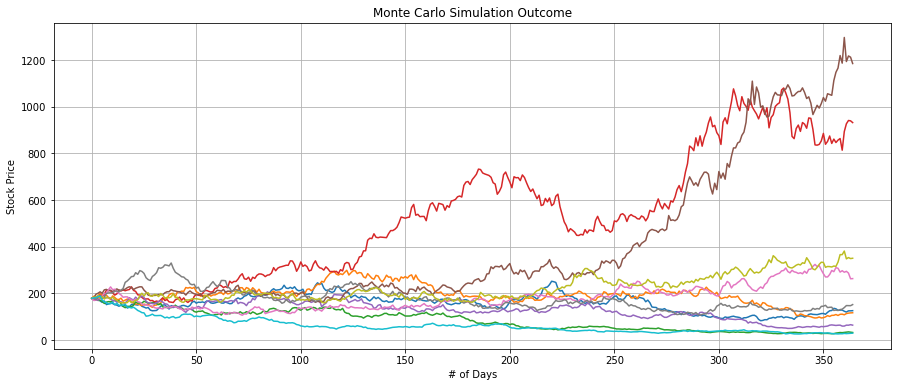

In [157]:
# Plot the last 10 out of the 10000 simulated stock prices
plt.figure(figsize=(15,6))
plt.plot(price_list[:, :10]);
plt.ylabel('Stock Price')
plt.xlabel('# of Days')
plt.title ('Monte Carlo Simulation Outcome')
plt.grid(True)